In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pyspark tensorflow keras

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install matplotlib

              Price          Open          High           Low           Vol  \
count   3244.000000   3244.000000   3244.000000   3244.000000  3.244000e+03   
mean   14009.913964  14020.446979  14241.587762  13803.243557  8.419560e+06   
std     9259.999481   9270.132185   9445.319184   9092.685629  8.172086e+06   
min     3754.400000   3814.500000   3844.500000   3604.300000  3.078900e+05   
25%     8309.725000   8283.275000   8463.725000   8147.500000  2.600000e+06   
50%    10735.550000  10742.900000  10861.900000  10625.600000  5.395000e+06   
75%    17102.550000  17044.975000  17410.575000  16693.425000  1.147500e+07   
max    49668.900000  50468.500000  51268.200000  48869.200000  6.956000e+07   

          Change %  
count  3244.000000  
mean      0.073027  
std       2.384726  
min      -7.000000  
25%      -1.140000  
50%       0.000000  
75%       1.182500  
max       8.860000  


C:\Users\FPT\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50], Loss: 0.5094524025917053
Epoch [20/50], Loss: 0.153364896774292
Epoch [30/50], Loss: 0.04159877076745033
Epoch [40/50], Loss: 0.020370883867144585
Epoch [50/50], Loss: 0.012366758659482002
Mean Squared Error on Test Data: 0.04991758614778519


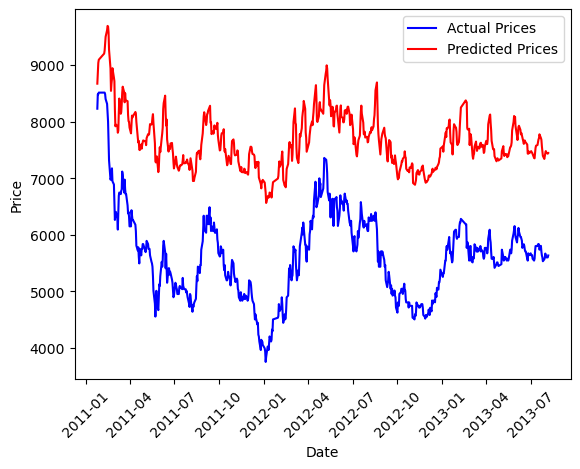

In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Đọc dữ liệu từ CSV
df = pd.read_csv("SSIHistoricalData.csv")

# Tiền xử lý dữ liệu
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
selected_columns = ["Price", "Open", "High", "Low", "Vol", "Change %"]

# Chuyển đổi kiểu dữ liệu và chuẩn hóa
df["Vol"] = df["Vol"].replace({',': ''}, regex=True).replace({'M': '*1e6', 'K': '*1e3'}, regex=True).map(pd.eval).astype(float)

# Xử lý cột "Change %"
df["Change %"] = df["Change %"].str.replace('%', '').astype(float)

# Xử lý các cột số có dấu phẩy
numeric_columns = ["Price", "Open", "High", "Low", "Vol"]
df[numeric_columns] = df[numeric_columns].replace({',': ''}, regex=True).astype(float)

# Tóm tắt thống kê của DataFrame
summary = df.describe()
print(summary)

# Chuẩn hóa giá trị
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[selected_columns])

# Chuẩn bị dữ liệu cho mô hình LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length-1:i+seq_length, 0]  # Dự đoán giá trị "Price"
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 100  # Độ dài của mỗi chuỗi
X, y = create_sequences(scaled_data, seq_length)

# Chia thành tập huấn luyện và tập kiểm thử
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Chuyển đổi thành PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Định nghĩa mô hình LSTM để dự đoán giá trị "Price"
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Tạo và huấn luyện mô hình LSTM mới
input_size = X_train_tensor.shape[2]
output_size = 1  # Dự đoán chỉ cột "Price"
hidden_size = 100
dropout_rate = 0.2

model = LSTMModel(input_size, hidden_size, output_size, dropout_rate)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# Dự đoán trên tập kiểm thử
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    mse = mean_squared_error(y_test_tensor[:, 0], test_outputs[:, 0])
    print(f'Mean Squared Error on Test Data: {mse}')

# Tính toán giá trị trung bình và độ lệch chuẩn của dữ liệu gốc
original_means = df[selected_columns].mean().values
original_stds = df[selected_columns].std().values

# Chuẩn hóa ngược lại giá trị của y_test
y_test_original = (y_test[:, 0] * original_stds[0]) + original_means[0]

# Chuẩn hóa ngược lại giá trị của test_outputs
test_outputs_original = (test_outputs[:, 0] * original_stds[0]) + original_means[0]

# Hiển thị trên đồ thị
plt.plot(df.index[-len(y_test):], y_test_original, label='Actual Prices', color='blue')
plt.plot(df.index[-len(y_test):], test_outputs_original, label='Predicted Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()
